In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Implémentation des fonctions

## Générer les données

In [49]:
def generate_data(d,n,theta,sigma):
    X = np.random.normal(0,1,size = (d, n))
    B = np.random.normal(0,sigma**2,n)
    Y = np.matmul(X.T, theta) + B
    return X, Y

## Risque moyen

In [50]:
def E(w,theta,sigma):
    return 1/2*np.linalg.norm(w-theta)**2 + sigma**2/2

## Risque empirique

In [51]:
def En(w,X,Y):
    return 1/(2*len(X))*np.linalg.norm(np.matmul(X.T,w)-Y)**2

## Gradient du risque empirique

In [52]:
def grad_En(w,X,Y):
    return 1/len(X)*np.matmul(X,np.matmul(X.T,w)-Y)

## Gradient stochastique suivant la loi uniforme

In [53]:
def grad_sto_En(w, X, Y, batch_size):
    n = X.shape[1]
    idx = np.random.choice( n, size=batch_size, replace=False)
    X_batch = X[:, idx]
    Y_batch = Y[idx]

    return grad_En(w, X_batch, Y_batch)

In [54]:
# def grad_sto_En(w, X, Y, batch_size):
#     n = len(Y)
#     idx = np.random.choice(n, batch_size, replace=False)
#     X_batch = X[idx, :]
#     Y_batch = Y[idx]
#     return grad_En(w, X_batch, Y_batch)

## Constante de Lipschitz de ∇En

In [55]:
def lipschitz_constant(X):
    n = X.shape[1]
    L = np.max(np.linalg.svd(X, compute_uv=False))

    return L / np.sqrt(n)

## Méthode d'optimisation la plus simple pour minimiser En

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Nous avons le problème d'optimisation suivant : min En, qui est un problème des moindres carrés. Ainsi, la méthode d'optimisation la plus efficace serait celle du gradient conjugué.
pas plus petit que 2/L, lemme de descente

Choix de la méthode d'optimisation pour minimiser En :
Si j'avais le choix, la méthode d'optimisation d'Adam serait la plus efficace pour minimiser En en raison de son adaptation des taux d'apprentissage pour chaque paramètre.

en sous forme matricielle moindres carrés et mérhode la plus efficace = gradient conjugué (méthode pr résoudre les pb linéaires)
si Xn transopse symétrique déf positive (loi normale)
si pas defi positive un gradient à pas constant =2/L algo de descente (lemme de descente)
</div>

## Descente de gradient à pas constant sur En

In [76]:
def gradient_constant(theta,sigma,step, w0, itermax):
    w = w0
    nbiter = 0
    E_n = [En(w0, X, Y)]
    E_k = [E(w0,theta,sigma)]
    
    while nbiter < itermax:
        descent = -grad_En(w,X,Y)
        w=w+step*descent
        E_n.append(En(w, X, Y))
        E_k.append(E(w,theta,sigma))
        nbiter+=1

    return w, E_n, E_k, nbiter

## Erreur d’approximation ∥$w^n$ − θ∥2 en fonction de n

In [57]:
def erreur_approx(w_star, theta):
    err = []
    for i in range(len(w_star)):
        err.append(np.abs(w_star[i]-theta[i]))
    return err

## Gradient stochastique à pas constant sur En

In [58]:
def grad_sto_constant(X, Y, w0, itermax, theta, sigma, n_batch, alpha):
    iter = 0
    w = w0
    En_k = [En(w, X, Y)]
    E_k = [E(w, theta, sigma)]    
    while (iter < itermax):
        w = w - alpha*grad_sto_En(w, X , Y, n_batch)
        En_k.append(En(w, X, Y))
        E_k.append(E(w, theta, sigma))
        iter = iter + 1 
    return w, En_k, E_k, iter

## Gradient stochastique à pas décroissant sur En

In [59]:
def grad_sto_decroissant(X, Y, w0, itermax, theta, sigma, initial_learning_rate, n_batch):
    iter = 0
    w = w0
    En_k = [En(w, X, Y)]
    E_k = [E(w, theta, sigma)]
    alpha = initial_learning_rate
    
    while (iter < itermax):
        w = w - alpha*grad_sto_En(w, X , Y, n_batch)
        En_k.append(En(w, X, Y))
        E_k.append(E(w, theta, sigma))
        iter = iter + 1 
        alpha = 1 / np.sqrt(iter) #mise à jour d'alpha avec beta qui est la vitesse de convergence
    return w, En_k, E_k, iter

##  Gradient stochastique online

In [60]:
def gradient_sto_online(X,Y, theta,sigma,step, w0, itermax, batch_size):
    w = w0
    nbiter = 0
    E_n = [En(w0, X, Y)]
    E_k = [E(w0,theta,sigma)]
    
    while nbiter < itermax:
        descent = -grad_sto_En(w, X , Y, n_batch)
        w=w+step*descent
        E_n.append(En(w, X, Y))
        E_k.append(E(w,theta,sigma))
        nbiter+=1

    return w, E_n, E_k, nbiter

## Méthode SAGA

In [61]:
def saga(X, Y, theta, sigma, lr, itermax, n_batch):
    d = X.shape[1]
    n = len(Y)
    w = np.zeros(d)
    iter = 0
    gradient_memory = np.zeros((n, d))
    avg_gradient = np.zeros(d)

    En_values = []
    E_values = []

    while iter<itermax:
        for i in np.random.choice(n, n_batch, replace=False):
            new_grad = grad_sto_En(w, X[i:i+1], Y[i:i+1], 1)
            w -= lr * (new_grad - gradient_memory[i] + avg_gradient)
            avg_gradient += (new_grad - gradient_memory[i]) / n
            gradient_memory[i] = new_grad

        En_current = En(w, X, Y)
        E_current = E(w, theta, sigma)
        En_values.append(En_current)
        E_values.append(E_current)
        iter+=1

    return w, En_values, E_values, iter


# Programme

In [62]:
d = 2
n = 100
theta = np.random.randn(d)
sigma = 2
# w = np.ones(d)

In [63]:
X, Y = generate_data(d,n,theta,sigma)

In [64]:
w = np.random.randn(d)

In [65]:
grad_sto_En(w,X,Y,10)

array([-2.17709083, -0.51963735])

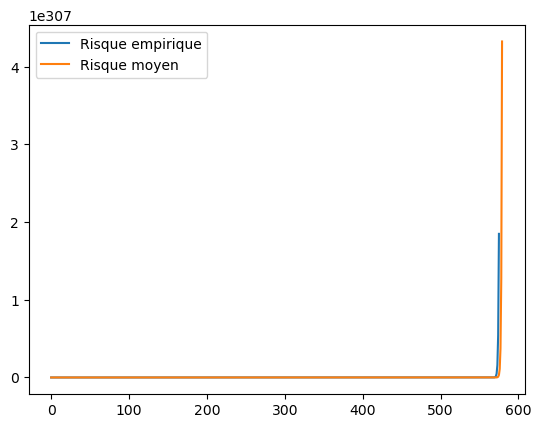

In [66]:
itermax = 1000
step = 0.05
w_grad_const,En_grad_const, E_grad_const, epoch_grad_const = gradient_constant(theta,sigma,step, w, itermax)

plt.plot(En_grad_const, label="Risque empirique")
plt.plot(E_grad_const, label="Risque moyen")
plt.legend()

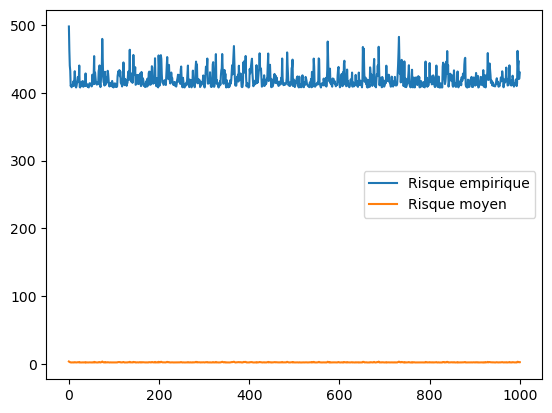

In [67]:
n_batch = 10
w_gradsto_const, En_gradsto_const, E_gradsto_const, epoch_gradsto_const = grad_sto_constant(X, Y, w, itermax, theta, sigma, n_batch, step)

plt.plot(En_gradsto_const, label="Risque empirique")
plt.plot(E_gradsto_const, label="Risque moyen")
plt.legend()

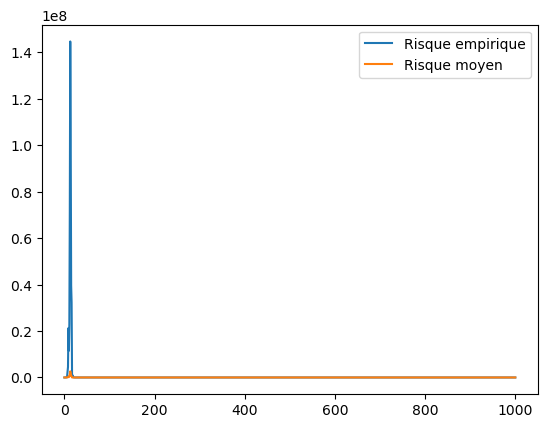

In [68]:
w_gradsto_dec, En_gradsto_dec, E_gradsto_dec, epoch_gradsto_dec = grad_sto_decroissant(X, Y, w, itermax, theta, sigma, step, n_batch)
plt.plot(En_gradsto_dec, label="Risque empirique")
plt.plot(E_gradsto_dec, label="Risque moyen")
plt.legend()

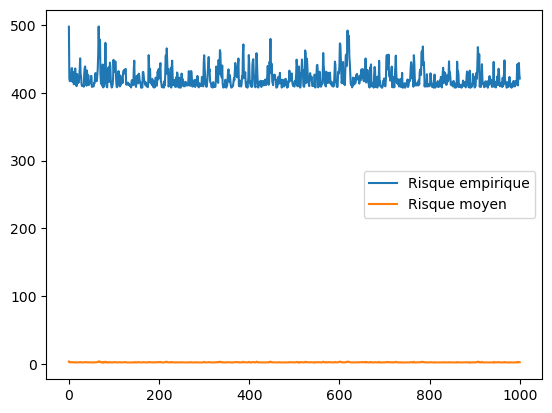

In [69]:
w_online, En_gradsto_online, E_gradsto_online, epoch_gradsto_online = gradient_sto_online(X,Y, theta,sigma,step, w, itermax, n_batch)
plt.plot(En_gradsto_online, label="Risque empirique")
plt.plot(E_gradsto_online, label="Risque moyen")
plt.legend()

In [70]:
# En_saga, E_saga, epoch_saga = saga(X, Y, theta, sigma, step, itermax, n_batch)

##  Comparaison les taux de convergence pour le risque empirique et le risque moyen en fonction du nombre d’epoch

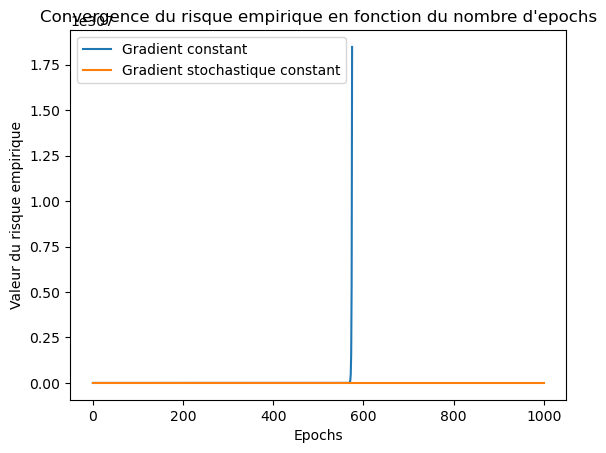

In [78]:
# Tracer les courbes de convergence
epochs1 = range(epoch_grad_const+1)  # Remplacer n_epochs par le nombre réel d'époques
epochs2 = range(epoch_gradsto_const+1)  # Remplacer n_epochs par le nombre réel d'époques

plt.plot(epochs1, En_grad_const, label='Gradient constant')
plt.plot(epochs2, En_gradsto_const, label='Gradient stochastique constant')
plt.xlabel('Epochs')
plt.ylabel('Valeur du risque empirique')
plt.title('Convergence du risque empirique en fonction du nombre d\'epochs')
plt.legend()
plt.show()

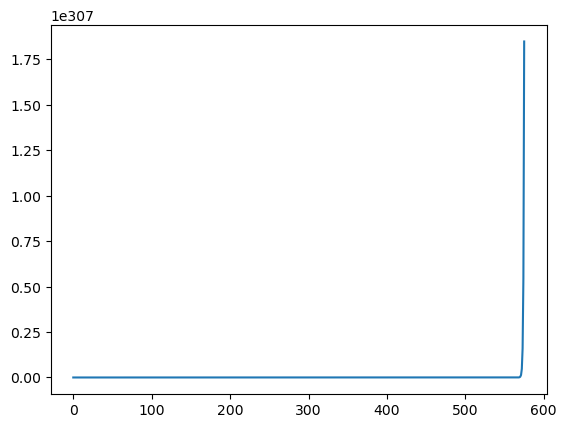

In [79]:
#comparaison des taux de convergence (faut-il faire la différence ? eps_est)
plt.plot([i for i in epochs1], En_grad_const)
# plt.plot([i for i in range(epoch+1)],E_k)

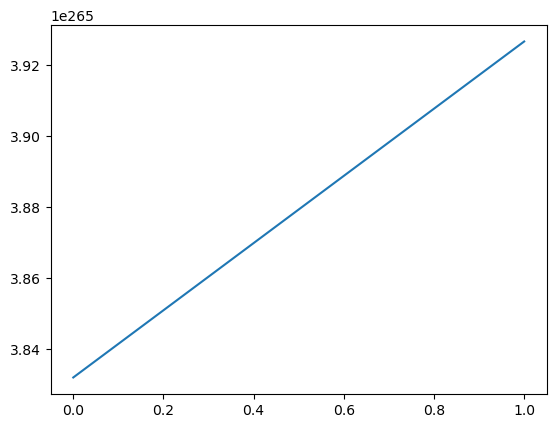

In [81]:
plt.plot(erreur_approx(w_grad_const, theta))

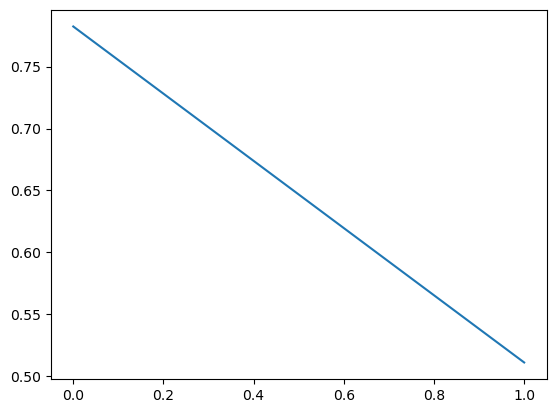

In [82]:
plt.plot(erreur_approx(w_gradsto_const, theta))

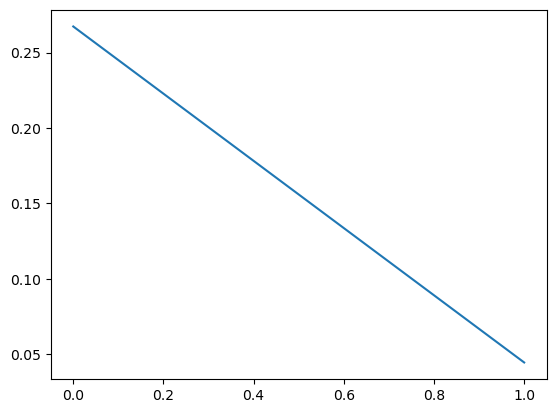

In [83]:
plt.plot(erreur_approx(w_gradsto_dec, theta))

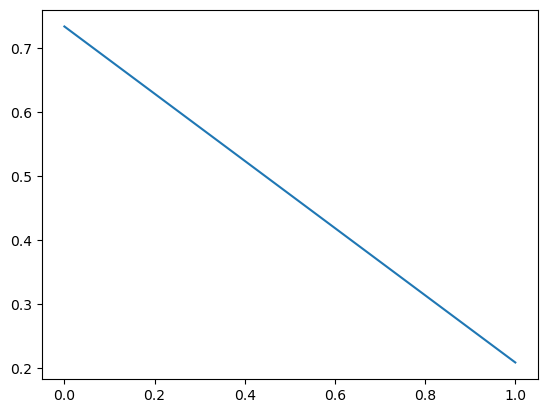

In [85]:
plt.plot(erreur_approx(w_online, theta))